# 4. Train all data

In [1]:
import os

base_dir = os.getcwd()

# dataset paths
dataset_path = os.path.join(base_dir, 'datasets')
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')

# 저장할 model path
save_dir = os.path.join(base_dir, 'saved_models')

classes = ['0_front', '1_back', '1_front', '2_back', '2_front', '5_front', 'ILU']

# train, validation의 각 class별 directory path
train_cls_dirs = [os.path.join(train_dir, c) for c in classes]
val_cls_dirs = [os.path.join(val_dir, c) for c in classes]

In [2]:
import cv2
import numpy as np

# Load dataset
def get_X_y_datas(class_dirs):
    X = []
    y = []
    for i, dir_path in enumerate(class_dirs):
        files = sorted(os.listdir(class_dirs[i]))
        files_paths = [os.path.join(dir_path, f) for f in files]
        
        for file_path in files_paths:
            img_bgr = cv2.imread(file_path, cv2.IMREAD_COLOR)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            input_img = img_rgb.astype(np.float32)/255.
            
            X.append(input_img)
            y.append(int(i))
            
    return np.array(X), np.array(y).astype(np.uint8)

In [3]:
from tensorflow.keras.utils import to_categorical

num_classes = 7

# Load all datas
X_all, y_all = get_all_X_y_datas(train_cls_dirs, val_cls_dirs)

# Shuffle
idx = np.random.permutation(len(X_all))
X_all, y_all = X_all[idx], y_all[idx]

# one-hot encoding
y_all = to_categorical(y_all, num_classes)

print(X_all.shape, y_all.shape)

(27876, 250, 200, 3) (27876, 7)


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop

# 학습에 사용할 callback
callbacks_list = [
    EarlyStopping(
        monitor='loss',
        patience=20,
    ),
    ModelCheckpoint(
        filepath=os.path.join(save_dir, 'hand_sign_simple_cnn.h5'),
        monitor='loss',
        save_best_only=True,
    ),
    ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=5,
        verbose=1
    )
]

In [5]:
import tensorflow as tf

from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

h = 250 # height
w = 200 # width
c = 3  # channels

# Multi GPU
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = models.Sequential()

    model.add(layers.Conv2D(16, 3, input_shape=(h, w, c,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, 3))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['acc'])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [6]:
batch_size = 64
n_epochs = 100

history = model.fit(X_all, y_all,
                    epochs=n_epochs, batch_size=batch_size,
                    callbacks=callbacks_list)

Train on 27876 samples
Epoch 1/100
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
27876/27876 [==============================] - 30s 1ms/sample - loss: 1.1122 - acc: 0.5873
Epoch 2/100
27876/27876 [==============================] - 10s 360us/sample - loss: 0.3400 - acc: 0.8895
Epoch 3/100
27876/27876 [==============================] - 10s 359us/sample - loss: 0.1813 - acc: 0.9405
Epoch 4/100
27876/27876 [==============================] - 10s 358us/sample - loss: 0.1169 - acc: 0.9616
Epoch 5/100
27876/27876 [==============================] - 10s 360us/sample - loss: 0.0879 - acc: 0.9698
Epoch 6/100
27876/27876 [==============================] - 10s 362us/sample - loss: 0.0682 - acc: 0.9766
Epoch 7/100
27876/27876 [====================

Epoch 68/100
27876/27876 [==============================] - 10s 358us/sample - loss: 3.2365e-07 - acc: 1.0000
Epoch 69/100
27876/27876 [==============================] - 10s 356us/sample - loss: 4.0264e-07 - acc: 1.0000
Epoch 70/100
27876/27876 [==============================] - 10s 361us/sample - loss: 8.7030e-07 - acc: 1.0000
Epoch 71/100
27876/27876 [==============================] - 10s 364us/sample - loss: 1.1367e-07 - acc: 1.0000
Epoch 72/100
27712/27876 [============================>.] - ETA: 0s - loss: 5.9798e-07 - acc: 1.0000
Epoch 00072: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
27876/27876 [==============================] - 10s 358us/sample - loss: 5.9448e-07 - acc: 1.0000
Epoch 73/100
27876/27876 [==============================] - 10s 356us/sample - loss: 1.5681e-07 - acc: 1.0000
Epoch 74/100
27876/27876 [==============================] - 10s 359us/sample - loss: 7.3669e-08 - acc: 1.0000
Epoch 75/100
27876/27876 [==============================] - 1

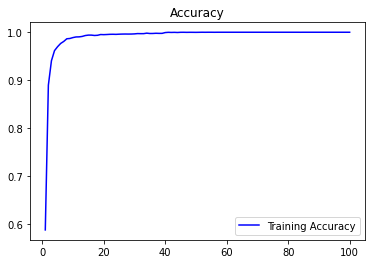

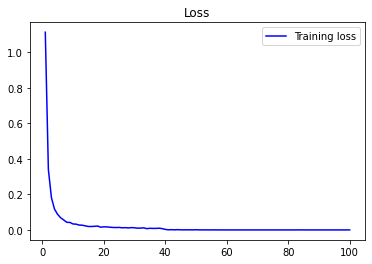

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy curve
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.title('Accuracy')
plt.legend()

plt.figure()

# Plot loss curve
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Loss')
plt.legend()

plt.show()